# Gooogle Colab - Driver Connection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
% cd /content/drive/MyDrive/SA_IMDB/

/content/drive/MyDrive/SA_IMDB


# SA-DBGRU

## Setup

In [3]:
!nvidia-smi

Tue Jul 19 06:38:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import Sequential
from keras import layers

In [5]:
# Load data 
train_dataset, test_dataset = tfds.load(
    'imdb_reviews', 
    split=["train", "test"],
    as_supervised=True
)

# Batches
BUFFER_SIZE = 10000
BATCH_SIZE = 128

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 1 Batch
for example, label in train_dataset.take(1):
  print(len(example))
  print('Texts: ', example.numpy()[:1])
  print('Labels: ', label.numpy()[:1])

128
Texts:  [b'I understand this film to be a debut feature and as such, it is very impressive. It has the feel and pacing of a "true indie", yet director Todd Yellin clearly possesses the photographic and editorial vision, command and judgment of a mature and seasoned professional. The shots are well framed and thought out and serve to move the story forward. He, and screenwriter Ivan Solomon deliver a story that has much more depth and lyricism than typical "paint by numbers" type scripts. It\'s a story that needs Judd Hirsch caliber character talent to have a shot at working. Judd is fantastic as usual; as are Scott Cohen and the beautiful Susan Floyd. The real surprise though is Elliot Korte who plays Adam Groden. Yellin was able to coax nuance out of the young actor in a role that could have been easily devalued by stereotype or overreach. Anyway, I found the film refreshing and entertaining.']
Labels:  [1]


## Encoder

In [6]:
# Encoder Vocab Size
VOCAB_SIZE = 10000

# Encoder
encoder = layers.TextVectorization(VOCAB_SIZE)

# Adapt TextVectorization for Train text to sets the layer's vocabulary
encoder.adapt(train_dataset.map(lambda text, label: text))

# Vocab
encoder.get_vocabulary()[:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

Once the vocabulary is set, the layer can encode text into indices. The tensors of **indices are 0-padded to the longest sequence in the batch** (unless you set a fixed `output_sequence_length`):

## DBGRU

### Architecture


![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

**Architecture of Bidirectional Model:**
1. This model can be build as a `Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

 This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


**Architecture of Deep Bidirectional Model:**

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://www.tensorflow.org/text/tutorials/images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer

### Model 

In [7]:
model = Sequential([
    encoder,
    layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True
        ),
    layers.Bidirectional(layers.GRU(64, return_sequences = True)),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.GRU(32)),
    layers.Dropout(0.3),
    layers.Dense(32, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        74496     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                        

In [8]:
# Compile
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(5 * 1e-3),
    metrics='acc'
)

# Train 
history_training = model.fit(
    train_dataset, 
    epochs=2
)

Epoch 1/2
196/196 [==============================] - 50s 185ms/step - loss: 0.4290 - acc: 0.7912
Epoch 2/2
196/196 [==============================] - 38s 191ms/step - loss: 0.1888 - acc: 0.9278


In [9]:
# Evaluation
train_loss, train_acc = model.evaluate(train_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

196/196 [==============================] - 17s 88ms/step - loss: 0.2839 - acc: 0.8827


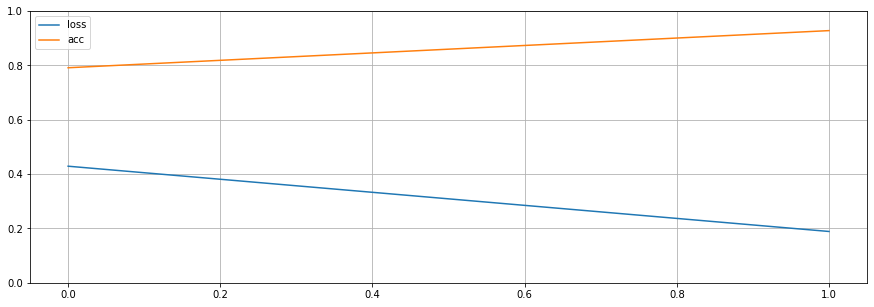

In [10]:
# Visualization
import matplotlib.pyplot as plt
pd.DataFrame(history_training.history).plot(figsize = (15,5))
plt.grid(True)
plt.gca().set_ylim(0,1);

In [11]:
# Predict
sample_text = ('The movie was cool. I would recommend this movie.')
model.predict(np.array([sample_text]))

array([[0.5004365]], dtype=float32)